In [3]:
## Only done once to get the files
# !unzip pkl_incep.zip
# !pip install bert-score


In [9]:
import os
print(os.getcwd())
import pickle
import keras
import numpy as np
from keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM,Add, Input, Concatenate
from tensorflow.keras.layers import TimeDistributed, Bidirectional, RepeatVector
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from keras.models import model_from_json
from keras.models import load_model

MAX_LENGTH = 39
VOCAB_SIZE = 1665
EMBED_SIZE = 300
PATH = os.getcwd()
act = 'relu'

/content


### Model Definition

In [5]:
imginp = Input(shape=(2048,))
imglay2 = Dense(EMBED_SIZE, activation=act)(imginp)
imglay3 = RepeatVector(MAX_LENGTH)(imglay2)
# # LSTM Part
textinp = Input(shape=(MAX_LENGTH,))
textlay1 = Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True)(textinp) 
textlay3 = LSTM(256, return_sequences=True)(textlay1)
textlay4 = TimeDistributed(Dense(EMBED_SIZE))(textlay3)
# # # Decoder part that combines both
declay1 = Add()([imglay3, textlay4])
declay3 = Bidirectional(LSTM(256, return_sequences=False))(declay1)
output = Dense(VOCAB_SIZE, activation="softmax")(declay3)
# Creating keras model
model = tf.keras.models.Model(inputs=[imginp, textinp],outputs=output)
model.summary()
model.layers[2]

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 39)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 39, 300)      499500      input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          614700      input_1[0][0]                    
_______________________________________________________________________________________

### Fixing the Embedding Matrix Weights & Preparing Input Data

In [10]:
embed_mat = pickle.load(open(f"{PATH}/embedding_matrix.pkl",'rb'))
print(f"Setting weights for Layer :{model.layers[2].__repr__()}")
model.layers[2].set_weights([embed_mat])
model.layers[2].trainable = False
model.summary()
# Reading the Token Object used in Data Generator
token = pickle.load(open(f"{PATH}/token.pkl", "rb"))
# Reading the Train, Valid & Test Data
img_desc = pickle.load(open(f"{PATH}/train_image_descriptions.pkl", "rb"))
img_feat = pickle.load(open(f"{PATH}/new_train_feat_inceptionv3.pkl", "rb"))

# valid_desc = pickle.load(open(f"{PATH}/valid_image_descriptions.pkl", "rb"))
# valid_feat = pickle.load(open(f"{PATH}/valid_image_feat_inceptionV3.pkl", "rb"))

Setting weights for Layer :<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f6c6873a9e8>
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 39)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 39, 300)      499500      input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          614700      input_1[0][0]  

### Compiling Model with Loss and Optimizer

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam')
print(f"{model.input}\n{model.output}")

[<tf.Tensor 'input_1:0' shape=(None, 2048) dtype=float32>, <tf.Tensor 'input_2:0' shape=(None, 39) dtype=float32>]
Tensor("dense_2/Softmax:0", shape=(None, 1665), dtype=float32)


### Creating a Python Func Data-Generator

In [8]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

def loader(img_desc, img_feat, token, bsize):
    inp1, inp2, label = [], [], []
    cnt = 0
    while 1:
        for k, desc in img_desc.items():
            cnt += 1
            ifeat = np.reshape(img_feat[k], (img_feat[k].shape[-1],))
            for d in desc:
                seq = token.texts_to_sequences([d])
                seq = seq[0]
                # print('here')
                for i in range(1, len(seq)):
                    inpseq, lbl = seq[:i], seq[i]
                    inpseq = pad_sequences([inpseq], maxlen=MAX_LENGTH, padding="post")[0]
                    lbl = to_categorical([lbl], num_classes=VOCAB_SIZE)[0]
                    inp1.append(ifeat)
                    inp2.append(inpseq)
                    label.append(lbl)
            if cnt == bsize:
                yield  (np.array(inp1),np.array(inp2)), np.array(label) # 
                inp1, inp2, label = [], [], []
                cnt = 0

## Training the Model

In [9]:
EPOCHS = 20
BATCH_SIZE = 64
steps = len(img_desc)//BATCH_SIZE
# steps_valid = len(valid_desc)//BATCH_SIZE
model.optimizer.lr = 1e-3

loss_train, loss_val = [], []
for i in range(EPOCHS):
  tr_loader = loader(img_desc,img_feat,token=token,bsize=BATCH_SIZE)

  H = model.fit(tr_loader, steps_per_epoch=steps, epochs=1, verbose=1,)
  loss_train.append(H.history['loss'][-1])

  # if i > 30: # reduce learning rate after epoch 30
  #   model.optimizer.lr = 1e-4      

19/93 [=====>........................] - ETA: 43s - loss: 2.2943

KeyboardInterrupt: ignored

## Visualizing the Loss

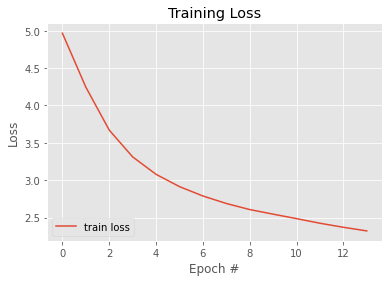

In [10]:
import matplotlib.pyplot as plt

stop_ep = len(loss_train)
e=plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,stop_ep),loss_train,label='train loss')
# plt.plot(np.arange(0,stop_ep),loss_val, label='val loss')
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()

### Save the Model for Inference

In [22]:
# model_json = model.to_json()
# with open(f"{os.getcwd()}/Vggfinal_model.json",'w') as json_file:
#     json_file.write(model_json)
# model.save_weights(f'{os.getcwd()}/Vggfinal_weight.h5')

## Load the Model for Inference

In [23]:
from keras.models import model_from_json
from keras.models import load_model

with open("InceptionV3model.json","r") as f:
    model = model_from_json(f.read())
model.load_weights("InceptionV3weights.h5")

# Load Test Data
test_desc = pickle.load(open(f"{PATH}/test_image_descriptions.pkl", "rb"))
test_feat = pickle.load(open(f"{PATH}/new_test_feat_inceptionv3.pkl", "rb"))

### Predict on Test Images

In [12]:
word2idx = pickle.load(open(f'{PATH}/word_to_ix.pkl','rb'))
idx2word = dict([(v, k) for k, v in word2idx.items()])

def predict_captions(image):
    start_word = ["startseq"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=MAX_LENGTH, padding='post')
        preds = model.predict([image, np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > MAX_LENGTH:
            break
            
    return ' '.join(start_word[1:-1])

In [13]:
pred_caption =[]
rf1, rf2, rf3, rf4, rf5 = [],[],[],[],[]
cnt = 0
for i, item in enumerate(test_desc.items()): # get those 1k images one by one
  """
  item -> (img_vec, desc)
  img_vec = (1, 512/2048)
  desc = list of gt captions
  """
  ### UNCOMMENT FOR A SINGLE CAPTION OUTPUT
  # cnt += 1
  # if cnt > 1:
  #   break
  img = np.reshape(test_feat[item[0]],(1,test_feat[item[0]].shape[0]))
  caption = predict_captions(img)
  pred_caption.append(caption)
  ### 
  desc = item[-1]
  desc = [d.lstrip('startseq') for d in desc]
  desc = [d.rstrip('endseq').strip() for d in desc]
  rf1.append(desc[0])
  rf2.append(desc[1])
  rf3.append(desc[2])
  rf4.append(desc[3])
  rf5.append(desc[4])
  # print(f"At {i}\r")

In [21]:
print(f"PREDICTED CAPTION:\n'{pred_caption[0]}'")
print(f"Reference Captions:\n'{rf1[0]}'\n'{rf2[0]}'\n'{rf3[0]}'")

PREDICTED CAPTION:
'a brown dog is jumping over a fence'
Reference Captions:
'the dogs are in the snow in front of a fence'
'the dogs play on the snow'
'two brown dogs playfully fight in the snow'


In [14]:
from bert_score import BERTScorer

references = rf4
candidates = pred_caption

scorer = BERTScorer(lang='en', rescale_with_baseline=True)
_, _, scores = scorer.score(references, candidates)
scores = scores.numpy()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,


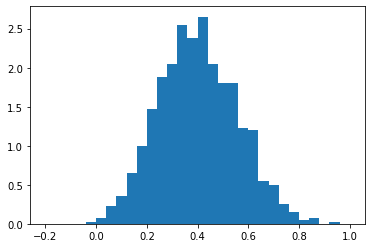

In [16]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=30, range=(-0.2, 1), density=True)
plt.show()